In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
!pip install python-docx
import docx


In [4]:
!pip install scikit-learn
!pip install pandas
!pip install emoji
!pip install num2words
!pip install nltk
!pip install matplotlib
!pip install wordcloud
!pip install python-docx
!pip install ipynb
!pip install seaborn
!pip install xgboost
!pip install unidecode

In [5]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import emoji
from num2words import num2words
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from matplotlib import colors
from wordcloud import WordCloud
from sklearn import metrics
import docx
from ipynb.fs.full.preprocessor_class import Preprocessor
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
train_data = pd.read_csv('data/shuffled_train_data.csv',index_col=None)
train_labels = pd.read_csv('data/shuffled_train_labels.csv',index_col=None)

test_data = pd.read_csv('data/test_data.csv',index_col=None)
test_labels = pd.read_csv('data/test_labels.csv',index_col=None)

train_data_plot = pd.read_csv('data/train_data_plot.csv',index_col=None)
test_data_plot = pd.read_csv('data/test_data_plot.csv',index_col=None)

train_data.shape

(2100, 1)

In [7]:
preprocessor = Preprocessor(set(stopwords.words('romanian')),None, None, True, True, True, True, False, True, True, True, True, False, False)

preprocessed_data = pd.DataFrame(columns=['text'])

preprocessed_train_data = pd.DataFrame(columns=['text'])
preprocessed_test_data = pd.DataFrame(columns=['text'])

preprocessed_train_data['text'] = train_data.apply(lambda row: preprocessor.preprocess(row.iloc[0]), axis = 1)
preprocessed_test_data['text'] = test_data.apply(lambda row: preprocessor.preprocess(row.iloc[0]), axis = 1)

#change the labels to numbers for xgb
train_labels['label'] = train_labels['label'].replace('no_depression', 0)
train_labels['label'] = train_labels['label'].replace('possible_depression', 1)
train_labels['label'] = train_labels['label'].replace('true_depression', 2)

test_labels['label'] = test_labels['label'].replace('no_depression', 0)
test_labels['label'] = test_labels['label'].replace('possible_depression', 1)
test_labels['label'] = test_labels['label'].replace('true_depression', 2)

In [8]:
preprocessed_test_data['text'] = preprocessed_test_data['text'].apply(lambda x: ' '.join(map(str, x)))
preprocessed_test_data

,text
0,mare durere fizica simtita clasa ten stomatolo...
1,petitie asf impotriva speculei asiguratorilor ...
2,ride sharing plecat proteste redditori masini ...
3,apasa trimite refugiat sprit ten salvati gold ...
4,politia datoria scurt depus plangere politie m...
...,...
1320,sfat buna neboie sfat facut doza vaccin contra...
1321,boli mintale soferii tir dn1 locuit an jumatat...
1322,freelancer gasesc clienti gasesc client job fr...
1323,furata cunostinta spune probe suficiente furat...


In [9]:
preprocessed_train_data['text'] = preprocessed_train_data['text'].apply(lambda x: ' '.join(map(str, x)))
preprocessed_train_data

,text
0,rant ajuns cumparam originalul postare tip imp...
1,true grit secretul succesului evident ideile c...
2,experiente schimbat mentalitatea buna experien...
3,subreddit trebui numeasca r depresie casual ti...
4,ticalosilor entr acte unchiul scrie decat marc...
...,...
2095,mersul sala eticheta mno inceput merg sala tov...
2096,maine sala controla emotiile long story short ...
2097,stie gasesc granita italiana intors sicilia ma...
2098,somn permanenta stiu fac efectiv somn momentul...


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
best_f1 = 0
chosen_parameters = {}
data = []

for max_features in [3000, 5000, None]:
    for n_gram in [(1, 1), (1, 2), (1, 3)]:
        for n_estimators in [50, 200]:
            for max_depth in [1, 10, 20]:
                for learning_rate in [0.001, 0.01]:
                    # initiate the CountVectorizer
                    count_vectorizer = CountVectorizer(max_features=max_features, ngram_range=n_gram)
                    train_count = count_vectorizer.fit_transform(preprocessed_train_data['text'])
                    test_count = count_vectorizer.transform(preprocessed_test_data['text'])
                    sm = SMOTE(random_state=42)
                    X_res, y_res = sm.fit_resample(train_count, train_labels['label']) # Use tfidf data for SMOTE

                    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
                    model.fit(X_res, y_res)

                    predictions = model.predict(test_count)
                    f1 = metrics.f1_score(test_labels['label'], predictions, average='macro')

                    print('max_features: {} n_gram: {}  n_estimators: {}  max_depth: {}  learning_rate: {}  f1: {}'.format(
                        max_features, n_gram, n_estimators, max_depth, learning_rate, f1))

                    data.append({
                        'max_features': max_features,
                        'n_gram': n_gram,
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'f1': f1
                    })

                    if f1 > best_f1:
                        best_f1 = f1
                        chosen_parameters["max_features"] = max_features
                        chosen_parameters["n_gram"] = n_gram
                        chosen_parameters["n_estimators"] = n_estimators
                        chosen_parameters["max_depth"] = max_depth
                        chosen_parameters["learning_rate"] = learning_rate

print(best_f1)
print(chosen_parameters)


max_features: 3000 n_gram: (1, 1)  n_estimators: 50  max_depth: 1  learning_rate: 0.001  f1: 0.2867383512544803
max_features: 3000 n_gram: (1, 1)  n_estimators: 50  max_depth: 1  learning_rate: 0.01  f1: 0.2867383512544803
max_features: 3000 n_gram: (1, 1)  n_estimators: 50  max_depth: 10  learning_rate: 0.001  f1: 0.2865748709122203
max_features: 3000 n_gram: (1, 1)  n_estimators: 50  max_depth: 10  learning_rate: 0.01  f1: 0.294645715117125
max_features: 3000 n_gram: (1, 1)  n_estimators: 50  max_depth: 20  learning_rate: 0.001  f1: 0.32565286913113
max_features: 3000 n_gram: (1, 1)  n_estimators: 50  max_depth: 20  learning_rate: 0.01  f1: 0.31586203505666594
max_features: 3000 n_gram: (1, 1)  n_estimators: 200  max_depth: 1  learning_rate: 0.001  f1: 0.2867383512544803
max_features: 3000 n_gram: (1, 1)  n_estimators: 200  max_depth: 1  learning_rate: 0.01  f1: 0.2867383512544803
max_features: 3000 n_gram: (1, 1)  n_estimators: 200  max_depth: 10  learning_rate: 0.001  f1: 0.2893437

In [11]:
#generate classification report for best parameters
tfidf = CountVectorizer(max_features = chosen_parameters["max_features"], ngram_range = chosen_parameters["n_gram"])

X_train_tfidf = tfidf.fit_transform(preprocessed_train_data["text"]).toarray()
X_test_tfidf = tfidf.transform(preprocessed_test_data["text"]).toarray()
model = XGBClassifier(n_estimators = chosen_parameters["n_estimators"], max_depth = chosen_parameters["max_depth"], learning_rate = chosen_parameters["learning_rate"])

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_tfidf, train_labels['label']) # Use tfidf data for SMOTE

model.fit(X_res, y_res)
predictions = model.predict(X_test_tfidf)
f1 = metrics.f1_score(test_labels['label'], predictions, average = 'macro')

print("F1 Score:", f1)
print(classification_report(test_labels['label'], predictions))

F1 Score: 0.3705346337606426
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1000
           1       0.21      0.29      0.25       250
           2       0.11      0.13      0.12        75

    accuracy                           0.59      1325
   macro avg       0.37      0.38      0.37      1325
weighted avg       0.64      0.59      0.61      1325



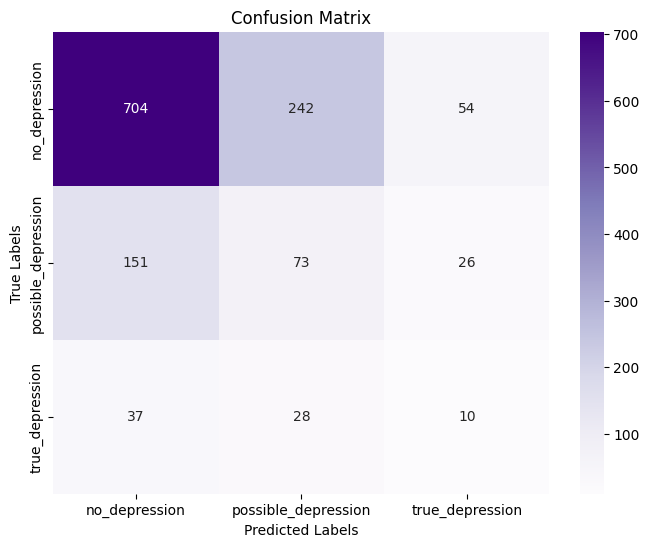

In [12]:
#generate confusion matrix for best parameters

conf_matrix = confusion_matrix(test_labels['label'], predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels = ['no_depression','possible_depression', 'true_depression'], yticklabels = ['no_depression','possible_depression', 'true_depression' ])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
doc = docx.Document()

doc.add_heading('Hiperparametrization', 0)

# Table data in a form of list
# data = (
#     (1, 'Geek 1'),
#     (2, 'Geek 2'),
#     (3, 'Geek 3')
# )

# Creating a table object
table = doc.add_table(rows=1, cols=6)
  # max_features: 1000 n_gram: (1, 1)  n_estimators: 10  max_depth: 1  learning_rate: 0.001  f1: 0.38419503322527343

# Adding heading in the 1st row of the table
row = table.rows[0].cells
row[0].text = 'max_features'
row[1].text = 'n_gram'
row[2].text = 'n_estimators'
row[3].text = 'max_depth'
row[4].text = 'learning_rate'
row[5].text = 'f1'

# Adding data from the list to the table
for elem in data:
    # Adding a row and then adding data in it.
    row = table.add_row().cells
    # Converting id to string as table can only take string input
    row[0].text = str(elem['max_features'])
    row[1].text = str(elem['n_gram'])
    row[2].text = str(elem['n_estimators'])
    row[3].text = str(elem['max_depth'])
    row[4].text = str(elem['learning_rate'])
    row[5].text = str(round(elem['f1'],4))
    #
# Now save the document to a location
doc.save('hiperparam_xgboversampling.docx')